In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, confusion_matrix
import matplotlib.pyplot as plt

np.random.seed(100)
LEVEL = 'level_1'

In [2]:
class SigmoidNeuron:
  
  def __init__(self):
    self.w = None
    self.b = None
    
  def perceptron(self, x):
    return np.dot(x, self.w.T) + self.b
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def grad_w_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred) * x
  
  def grad_b_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred)
  
  def grad_w_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred * x
    elif y == 1:
      return -1 * (1 - y_pred) * x
    else:
      raise ValueError("y should be 0 or 1")
    
  def grad_b_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred 
    elif y == 1:
      return -1 * (1 - y_pred)
    else:
      raise ValueError("y should be 0 or 1")
  
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, loss_fn="mse", display_loss=False):
    
    # initialise w, b
    if initialise:
      self.w = np.random.randn(1, X.shape[1])
      self.b = 0
      
    if display_loss:
      loss = {}
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dw = 0
      db = 0
      for x, y in zip(X, Y):
        if loss_fn == "mse":
          dw += self.grad_w_mse(x, y)
          db += self.grad_b_mse(x, y) 
        elif loss_fn == "ce":
          dw += self.grad_w_ce(x, y)
          db += self.grad_b_ce(x, y)
      self.w -= learning_rate * dw
      self.b -= learning_rate * db
      
      if display_loss:
        Y_pred = self.sigmoid(self.perceptron(X))
        if loss_fn == "mse":
          loss[i] = mean_squared_error(Y, Y_pred)
        elif loss_fn == "ce":
          loss[i] = log_loss(Y, Y_pred)
    
    if display_loss:
      plt.plot(list(loss.values()))
      plt.xlabel('Epochs')
      if loss_fn == "mse":
        plt.ylabel('Mean Squared Error')
      elif loss_fn == "ce":
        plt.ylabel('Log Loss')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.sigmoid(self.perceptron(x))
      Y_pred.append(y_pred)
    return np.array(Y_pred)

In [3]:
def read_all(folder_path, key_prefix=""):
    '''
    It returns a dictionary with 'file names' as keys and 'flattened image arrays' as values.
    '''
    print("Reading:")
    images = {}
    files = os.listdir(folder_path)
    for i, file_name in tqdm_notebook(enumerate(files), total=len(files)):
        file_path = os.path.join(folder_path, file_name)
        image_index = key_prefix + file_name[:-4]
        image = Image.open(file_path)
        image = image.convert("L")
        images[image_index] = np.array(image.copy()).flatten()
        image.close()
    return images

In [13]:
languages = ['ta', 'hi', 'en']
trainPath = "input/padhai-text-non-text-classification-level-1/"+LEVEL+"_train/"+LEVEL+"/"
testPath = "input/padhai-text-non-text-classification-level-1/"+LEVEL+"_test/kaggle_"+LEVEL
images_train = read_all(trainPath+"background", key_prefix='bgr_') # change the path
for language in languages:
  images_train.update(read_all(trainPath+language, key_prefix=language+"_" ))
print(len(images_train))

images_test = read_all(testPath, key_prefix='') # change the path
print(len(images_test))

Reading:


/home/himank/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Reading:



Reading:



Reading:



892
Reading:



297


In [14]:
! cd ../input

/usr/bin/sh: 1: cd: can't cd to ../input


In [15]:
list(images_test.keys())[:5]

['195', '206', '137', '148', '66']

In [16]:
X_train = []
Y_train = []
for key, value in images_train.items():
    X_train.append(value)
    if key[:4] == "bgr_":
        Y_train.append(0)
    else:
        Y_train.append(1)

ID_test = []
X_test = []
for key, value in images_test.items():
  ID_test.append(int(key))
  X_test.append(value)
  
        
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)

print(X_train.shape, Y_train.shape)
print(X_test.shape)

(892, 256) (892,)
(297, 256)


In [17]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

/home/himank/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


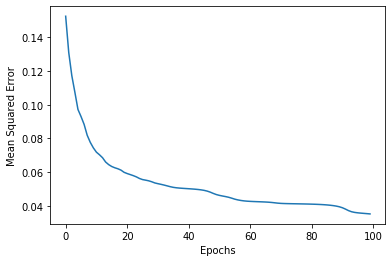

In [18]:
sn_mse = SigmoidNeuron()
sn_mse.fit(X_scaled_train, Y_train, epochs=100, learning_rate=0.015, loss_fn="mse", display_loss=True)

/home/himank/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


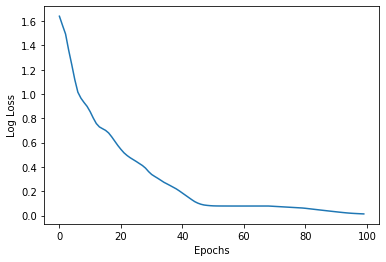

In [19]:
sn_ce = SigmoidNeuron()
sn_ce.fit(X_scaled_train, Y_train, epochs=100, learning_rate=0.015, loss_fn="ce", display_loss=True)

In [20]:
def print_accuracy(sn):
  Y_pred_train = sn.predict(X_scaled_train)
  Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
  accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
  print("Train Accuracy : ", accuracy_train)
  print("-"*50)

In [21]:
print_accuracy(sn_mse)
print_accuracy(sn_ce)

Train Accuracy :  0.9641255605381166
--------------------------------------------------
Train Accuracy :  0.9988789237668162
--------------------------------------------------


## Sample Submission

In [26]:
Y_pred_test = sn_ce.predict(X_scaled_test)
Y_pred_binarised_test = (Y_pred_test >= 0.5).astype("int").ravel()

submission = {}
submission['ImageId'] = ID_test
submission['Class'] = Y_pred_binarised_test

submission = pd.DataFrame(submission)
submission = submission[['ImageId', 'Class']]
submission = submission.sort_values(['ImageId'])
submission.to_csv("Output/submisision.csv", index=False)

In [27]:
submission.values

array([[  0,   1],
       [  1,   0],
       [  2,   1],
       [  3,   1],
       [  4,   1],
       [  5,   0],
       [  6,   0],
       [  7,   0],
       [  8,   0],
       [  9,   1],
       [ 10,   1],
       [ 11,   0],
       [ 12,   1],
       [ 13,   0],
       [ 14,   1],
       [ 15,   0],
       [ 16,   1],
       [ 17,   1],
       [ 18,   0],
       [ 20,   1],
       [ 21,   1],
       [ 22,   0],
       [ 23,   1],
       [ 24,   1],
       [ 25,   1],
       [ 26,   1],
       [ 27,   0],
       [ 28,   0],
       [ 29,   1],
       [ 30,   1],
       [ 31,   1],
       [ 32,   0],
       [ 33,   1],
       [ 34,   1],
       [ 35,   0],
       [ 36,   1],
       [ 37,   0],
       [ 38,   0],
       [ 39,   1],
       [ 40,   0],
       [ 41,   1],
       [ 42,   0],
       [ 43,   0],
       [ 44,   0],
       [ 45,   1],
       [ 46,   1],
       [ 47,   0],
       [ 48,   0],
       [ 49,   1],
       [ 50,   0],
       [ 51,   1],
       [ 52,   0],
       [ 53,